#Setting up the environment keys
If you are running this notebook in colab , make sure you follow the required process of setting up keys.

If you are running locally:
make sure you create .env file and include the key 'HF_TOKEN'

In [5]:
try:
  from kaggle_secrets import UserSecretsClient
except:
  pass
from huggingface_hub import HfApi

try:
    user_secrets = UserSecretsClient()
    token = user_secrets.get_secret("NIGERFOODAI")
except:
    token=os.getenv("HF_TOKEN")
    if token==None:
      from google.colab import userdata
      token=userdata.get('HF_TOKEN')


os.environ["HF_TOKEN"] = token
api = HfApi()

# Importing the Required Libraries
## Ultralytics plays a major role in the model development.

In [ ]:
!pip install -q ultralytics



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.3 MB/s eta 0:00:00


# Loading the the Niger Food Classification Dataset


In [2]:
import os

class_names=['ewedu',
 'nkwobi',
 'garriandgrounut',
 'jellof',
 'edikakong',
 'pufpuf',
 'ofeowerri',
 'bitterleaf',
 'banga',
 'moimoi',
 'ogbono',
 'egusi',
 'akarabread',
 'okra']

if not os.path.exists('./nigfoodai'):
    os.system('git lfs install')
    os.system('git clone https://huggingface.co/datasets/GboyeStack/NIgerFood ./nigfoodai')
    for file in os.listdir('./nigfoodai'):
        if file not in class_names:
            os.system(f'rm -rf ./nigfoodai/{file}')

assert len(os.listdir('nigfoodai'))==14

In [3]:
import os

def get_dir_size(path):
    total = 0
    with os.scandir(path) as it:
        for entry in it:
            try:
                if entry.is_file(follow_symlinks=False):
                    total += entry.stat(follow_symlinks=False).st_size
                elif entry.is_dir(follow_symlinks=False):
                    total += get_dir_size(entry.path)
            except Exception:
                # handle permissions, race conditions, etc.
                pass
    return total

def human_readable_size(size, decimal_places=2):
    for unit in ["B", "KB", "MB", "GB", "TB", "PB"]:
        if size < 1024:
            return f"{size:.{decimal_places}f} {unit}"
        size /= 1024
    return f"{size:.{decimal_places}f} PB"


folder = "nigfoodai"
size_bytes = get_dir_size(folder)
print("Folder size:", human_readable_size(size_bytes))



Folder size: 861.34 MB


In [ ]:
# api.upload_large_folder(
#     folder_path="/kaggle/working/nigfoodai",
#     repo_id="GboyeStack/NIgerFood",
#     repo_type="dataset",
#     ignore_patterns=["nigfoodai/*","__pycache__/*",'nigfoodai-yolo/*'] #This ensures that the nigfoodai folder isn't included as this makes the upload slower and eventually take up space on hugging face

# )

# Analysing the Distribution of the samples per class
#### This was done to address the significant  class imbalance in the dataset

Text(0.5, 1.0, 'Bar Chart Showing the Distribution of Samples ')

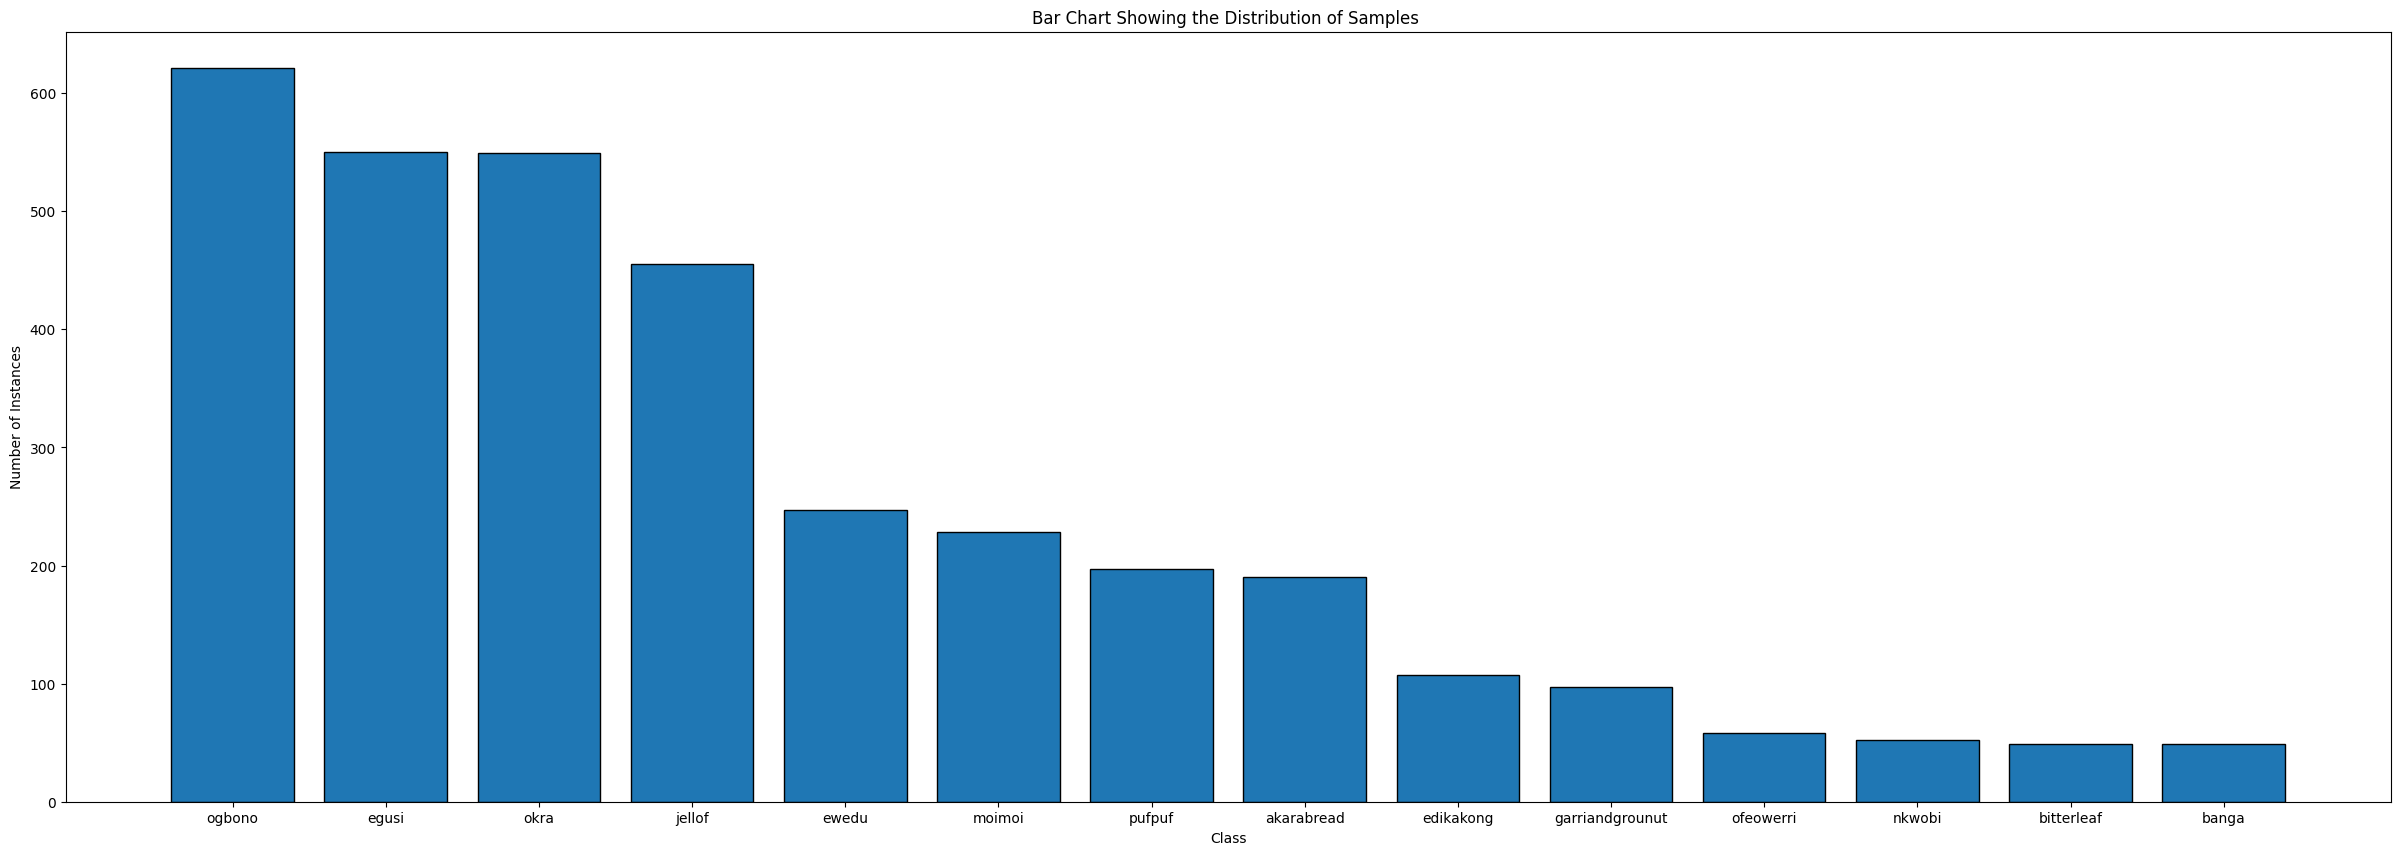

In [6]:
import os
import matplotlib.pyplot as plt
classes=os.listdir('nigfoodai')
instances_per_class={class_name:len(os.listdir(f"nigfoodai/{class_name}"))for class_name in classes if class_name!='.git'}
instances_per_class= dict(sorted(instances_per_class.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(30, 10))
plt.bar(list(instances_per_class.keys()),list(instances_per_class.values()),edgecolor="black", )
plt.xlabel("Class")
plt.ylabel("Number of Instances")
plt.title("Bar Chart Showing the Distribution of Samples ")



#Note there is a significant class imbalance

In [7]:
import torch
import torchvision.transforms as T

from ultralytics import YOLO
from ultralytics.data.dataset import ClassificationDataset
from ultralytics.models.yolo.classify import ClassificationTrainer, ClassificationValidator


class CustomizedDataset(ClassificationDataset):

    """A customized dataset class for image classification with enhanced data augmentation transforms."""

    def __init__(self, root: str, args, augment: bool = False, prefix: str = ""):

        """Initialize a customized classification dataset with enhanced data augmentation transforms."""

        super().__init__(root, args, augment, prefix)

        # Add your custom training transforms here
        train_transforms = T.Compose(
            [
                T.Resize((args.imgsz, args.imgsz)),
                T.RandomHorizontalFlip(p=args.fliplr),
                T.RandomVerticalFlip(p=args.flipud),
                T.RandAugment(interpolation=T.InterpolationMode.BILINEAR),
                T.ColorJitter(brightness=args.hsv_v, contrast=args.hsv_v, saturation=args.hsv_s, hue=args.hsv_h),
                T.ToTensor(),
                T.Normalize(mean=torch.tensor(0), std=torch.tensor(1)),
                T.RandomErasing(p=args.erasing, inplace=True),
            ]
        )

        # Add your custom validation transforms here
        val_transforms = T.Compose(
            [
                T.Resize((args.imgsz, args.imgsz)),
                T.ToTensor(),
                T.Normalize(mean=torch.tensor(0), std=torch.tensor(1)),
            ]
        )
        self.torch_transforms = train_transforms if augment else val_transforms




Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [9]:
class CustomizedTrainer(ClassificationTrainer):
    """A customized trainer class for YOLO classification models with enhanced dataset handling."""

    def build_dataset(self, img_path: str, mode: str = "train", batch=None):
        """Build a customized dataset for classification training and the validation during training."""
        return CustomizedDataset(root=img_path, args=self.args, augment=mode == "train", prefix=mode)


class CustomizedValidator(ClassificationValidator):
    """A customized validator class for YOLO classification models with enhanced dataset handling."""

    def build_dataset(self, img_path: str, mode: str = "train"):
        """Build a customized dataset for classification standalone validation."""
        return CustomizedDataset(root=img_path, args=self.args, augment=mode == "train", prefix=self.args.split)

## Converting dataset format to a format more aligned with yolov11 classification format

In [10]:
import os
import shutil
import random
import tqdm

# Paths
src_root = "nigfoodai"       # your original dataset
dst_root = "nigfoodai-yolo"  # destination folder

splits = ["train", "val", "test"]
split_ratios = [0.7, 0.2, 0.1]  # 70% train, 20% val, 10% test


def convert_yolo(src_root,dst_root,splits,split_ratios):

    os.makedirs(dst_root, exist_ok=True)
    for split in splits:
        os.makedirs(os.path.join(dst_root, split), exist_ok=True)

    # Loop through each class
    for class_name in tqdm.tqdm(os.listdir(src_root),desc='Converting'):
        class_path = os.path.join(src_root, class_name)
        if not os.path.isdir(class_path):
            continue

        # Create class folders in train/val/test
        for split in splits:
            os.makedirs(os.path.join(dst_root, split, class_name), exist_ok=True)

        # List all images in this class
        images = os.listdir(class_path)
        random.shuffle(images)

        n_total = len(images)
        n_train = int(split_ratios[0] * n_total)
        n_val = int(split_ratios[1] * n_total)

        train_imgs = images[:n_train]
        val_imgs = images[n_train:n_train+n_val]
        test_imgs = images[n_train+n_val:]

        # print(f'Train_images_found: {len(train_imgs)}')
        # print(f'Validation_images_found: {len(val_imgs)}')
        # print(f'Test_images_found: {len(test_imgs)}')
        # print(f'path to converted data:{dst_root}')

        # Move/copy images
        for img in train_imgs:
                shutil.copy(os.path.join(class_path, img), os.path.join(dst_root, "train", class_name, img))
        for img in val_imgs:
                shutil.copy(os.path.join(class_path, img), os.path.join(dst_root, "val", class_name, img))
        for img in test_imgs:
                shutil.copy(os.path.join(class_path, img), os.path.join(dst_root, "test", class_name, img))
    return dst_root

path=convert_yolo(src_root=src_root,dst_root=dst_root,splits=splits,split_ratios=split_ratios)



Converting: 100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


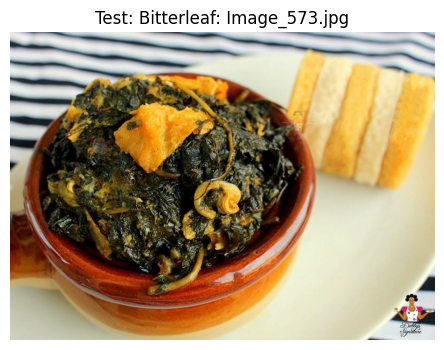

In [12]:
from PIL import Image
import matplotlib.pyplot as plt
import random

class_=random.choice(os.listdir(src_root))
split=random.choice(splits)
path=dst_root
path_=f'{path}/test/{class_}'
filenames=os.listdir(path_)
filename=random.choice(filenames)
img_path=f'{path_}/{filename}'

# open with PIL
img = Image.open(img_path).convert("RGB")
# show with matplotlib
plt.figure(figsize=(6, 4))
plt.imshow(img)
plt.axis("off")          # hide axes
plt.title(f'{split.title()}: {class_.title()}: {filename}')
plt.show()




# Downloading the model weights for yolov11

In [77]:
def get_latest_path(root_dir):
  files={filename.split('train')[-1]:filename for filename in os.listdir(root_dir) if filename.startswith("train")}

  return files[max(files.keys())]

In [78]:
if  os.path.exists('./runs'):
    try:
        os.system('git clone https://huggingface.co/GboyeStack/NigerFoodAi ./model_clone')
    except:
        os.system("wget -O /kaggle/working/yolo11n-cls.pt 'https://github.com/ultralytics/assets/releases/download/v8.3.0/yolo11n-cls.pt'")
        weights_path="./yolo11n-cls.pt"
    else:
        shutil.copytree('./model_clone/runs','./runs')
        shutil.rmtree('./model_clone')
        weights_path=f"./runs/classify/{get_latest_path('./runs/classify')}/weights/last.pt"




heelo
./runs/classify/train5/weights/last.pt


# Training the model

In [16]:
from ultralytics import YOLO
import os
import os
os.environ["WANDB_MODE"] = "disabled"


# Load a model
# model = YOLO("/kaggle/working/yolo11n-cls.pt")
model = YOLO(weights_path)
model.train(data=path, trainer=CustomizedTrainer, epochs=100, imgsz=224,resume=False)

Ultralytics 8.3.206 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=nigfoodai-yolo, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=./runs/classify/train/weights/last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plo

ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a3d9c386000>
curves: []
curves_results: []
fitness: 0.975877195596695
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9517543911933899, 'metrics/accuracy_top5': 1.0, 'fitness': 0.975877195596695}
save_dir: PosixPath('/content/runs/classify/train5')
speed: {'preprocess': 0.10085684503095688, 'inference': 0.46717373391944866, 'loss': 0.0003826301133557807, 'postprocess': 0.0005079429819600415}
task: 'classify'
top1: 0.9517543911933899
top5: 1.0

# Model Evaluation

In [17]:
results=model.val(data=path, validator=CustomizedValidator, imgsz=224)

Ultralytics 8.3.206 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 47 layers, 1,543,958 parameters, 0 gradients, 3.2 GFLOPs
train: /content/nigfoodai-yolo/train... found 2407 images in 14 classes ✅ 
val: /content/nigfoodai-yolo/val... found 684 images in 14 classes ✅ 
test: /content/nigfoodai-yolo/test... found 358 images in 14 classes ✅ 
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1833.5±1720.9 MB/s, size: 75.2 KB)
val: Scanning /content/nigfoodai-yolo/val... 684 images, 0 corrupt: 100% ━━━━━━━━━━━━ 684/684 1.4Mit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 43/43 2.6it/s 16.6s
                   all      0.898      0.996
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/runs/classify/val


# Plot the confusion matrix

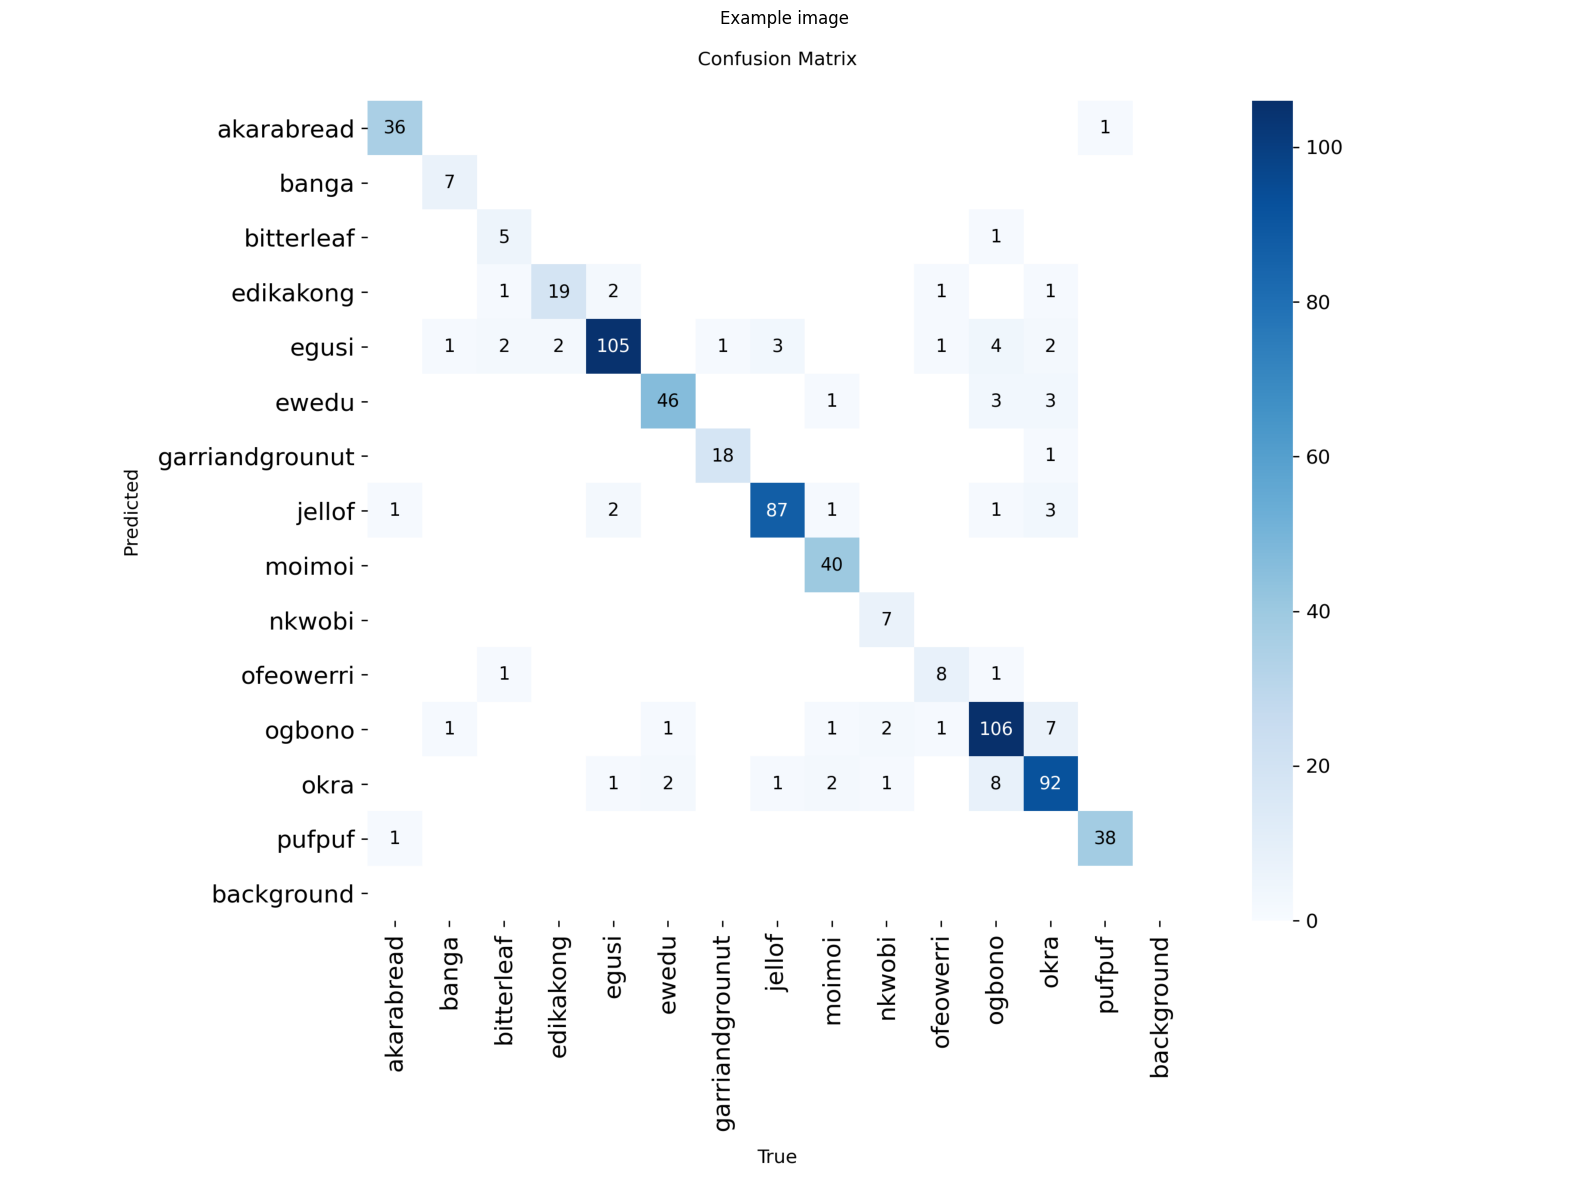

In [18]:
cm = results.confusion_matrix  # or similar attribute
cm.plot(normalize=False, save_dir="./runs")
img_path=r'./runs/confusion_matrix.png'

img = Image.open(img_path).convert("RGB")
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.axis("off")          # hide axes
plt.title("Example image")
plt.show()

# Running Predictions with the model

In [19]:
from PIL import Image
import matplotlib.pyplot as plt
import random


def predict(image_path,trained_model,plot):
    if not image_path:
        class_=random.choice(list(model.names.values()))
        path_=f'{path}/test/{class_}'
        filenames=os.listdir(path_)

        image_path=f'{path_}/{random.choice(filenames)}'

        # open with PIL
    img = Image.open(image_path).convert("RGB")

        # open with PIL
    results = model(image_path)[0]

    if plot:
        # show with matplotlib
        plt.figure(figsize=(6, 4))
        plt.imshow(img)
        plt.axis("off")          # hide axes
        plt.title(f'Expected:{class_} |||   Predicted:{model.names[results.probs.top1]} |||  Confidence:{round(float(results.probs.top1conf),2)}')
        plt.show()





image 1/1 /content/nigfoodai-yolo/test/ogbono/Image_103.jpg: 224x224 ogbono 0.77, banga 0.10, ewedu 0.09, okra 0.02, edikakong 0.01, 3.9ms
Speed: 5.5ms preprocess, 3.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)


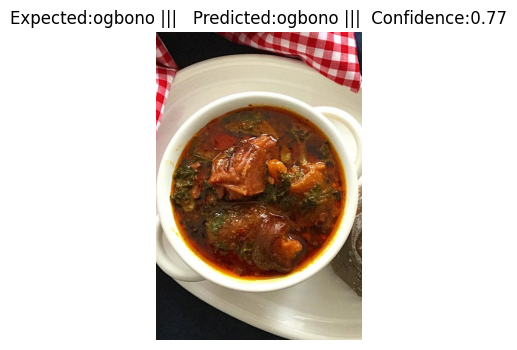

In [53]:
predict(image_path=None,trained_model=model,plot=True)

# Upload model to hugging face

In [60]:
response=input('Do you want to upload the model to hugging face? (y/n)')
if response=='y':
    api.upload_folder(
        folder_path="./runs",
        path_in_repo="runs",
        repo_id="GboyeStack/NigerFoodAi",
        repo_type="model",
        # ignore_patterns=["nigfoodai/*",
        #                  "__pycache__/*",
        #                  'nigfoodai-yolo/*',
        #                  'sample_data/*',
        #                  '.config/*',
        #                  './**/*.pt',
        #                  './**/*.py'] #This ensures that the nigfoodai folder isn't included as this makes the upload slower and eventually take up space on hugging face

    )


Do you want to upload the model to hugging face? (y/n)y


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...rain/confusion_matrix.png: 100%|##########|  247kB /  247kB            

  ...ion_matrix_normalized.png: 100%|##########|  317kB /  317kB            

  ...fy/train/train_batch1.jpg: 100%|##########|  165kB /  165kB            

  ...ion_matrix_normalized.png: 100%|##########|  287kB /  287kB            

  ...fy/train/train_batch2.jpg: 100%|##########|  146kB /  146kB            

  ...lassify/train/results.png: 100%|##########|  140kB /  140kB            

  ...fy/train/train_batch0.jpg: 100%|##########|  167kB /  167kB            

  ...assify/train5/results.png: 100%|##########|  172kB /  172kB            

  ...ain5/train_batch13590.jpg: 100%|##########|  142kB /  142kB            

  ...y/train5/train_batch2.jpg: 100%|##########|  142kB /  142kB            

No files have been modified since last commit. Skipping to prevent empty commit.
